In [161]:
import mne
import matplotlib.pyplot as plt

filePath = "/Users/jonathan/Documents/coding/alljoined/stimulus-emotiv/recordings/subj_8/session_2/block_1/Subject 8, Session 2, Block 1 Recording_EPOCFLEX_213075_2024.05.09T12.22.50.07.00.md.edf"
raw = mne.io.read_raw_edf(filePath, preload=True)

Extracting EDF parameters from /Users/jonathan/Documents/coding/alljoined/stimulus-emotiv/recordings/subj_8/session_2/block_1/Subject 8, Session 2, Block 1 Recording_EPOCFLEX_213075_2024.05.09T12.22.50.07.00.md.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 639  =      0.000 ...     4.992 secs...


In [162]:
raw.info

Measurement date,"May 09, 2024 12:22:50 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,123 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


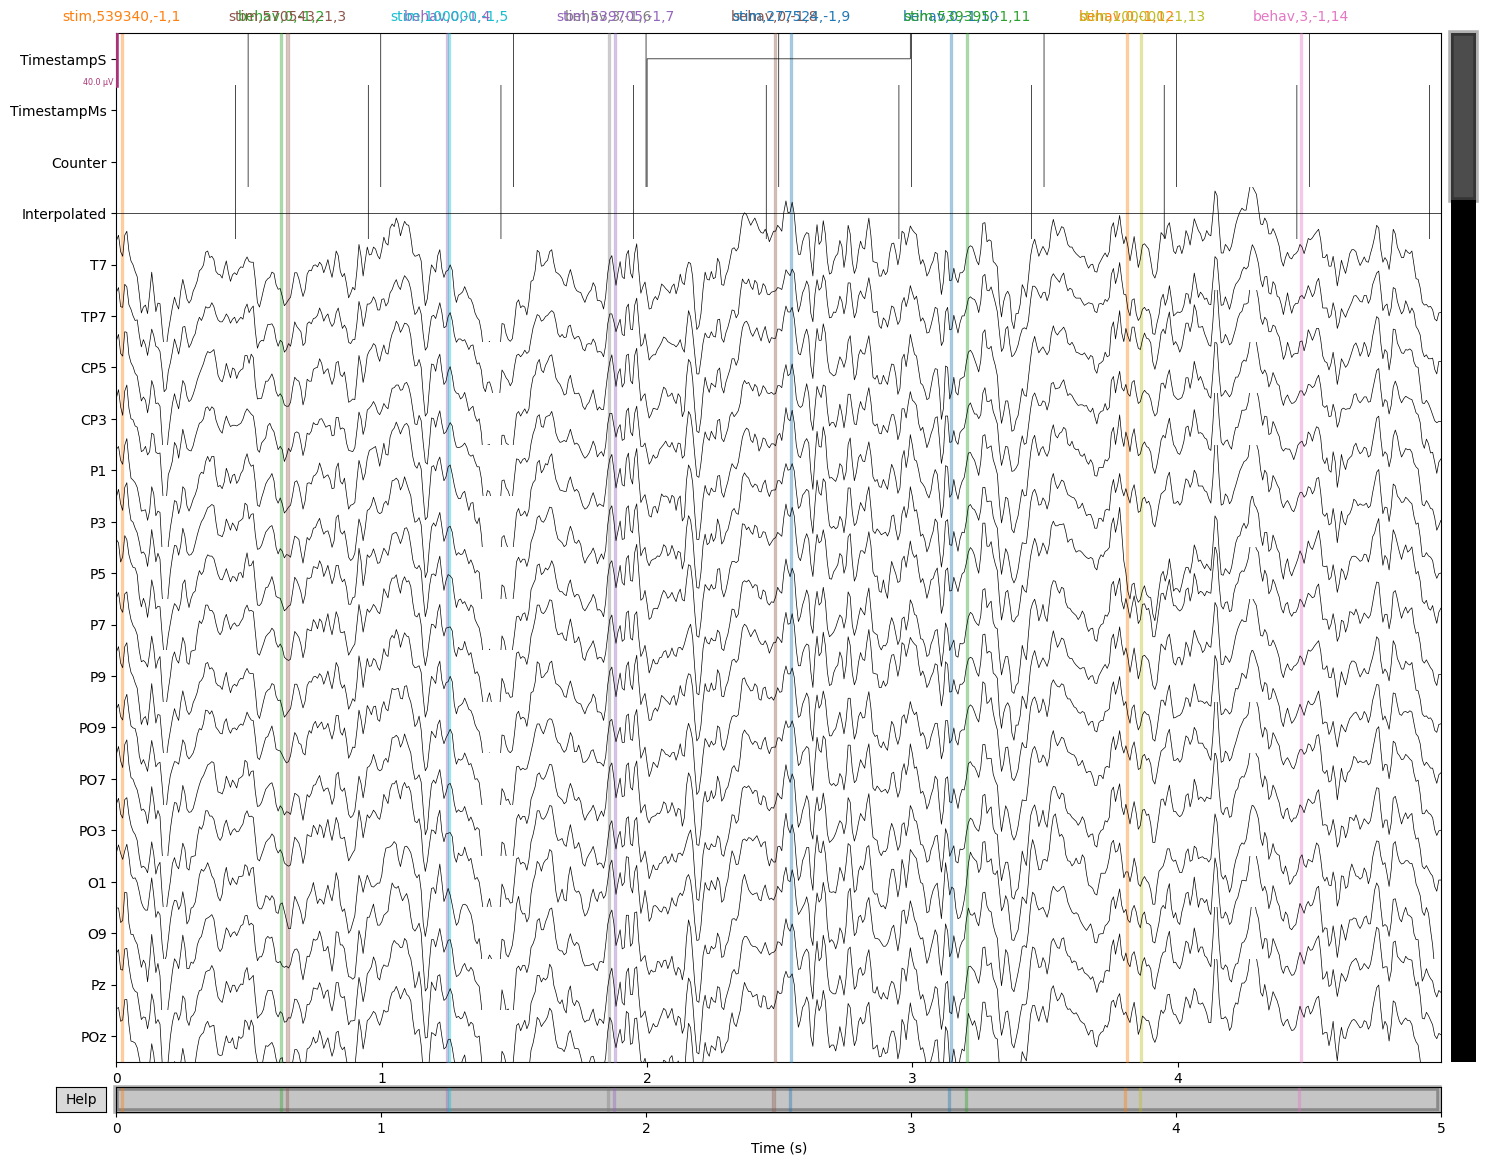

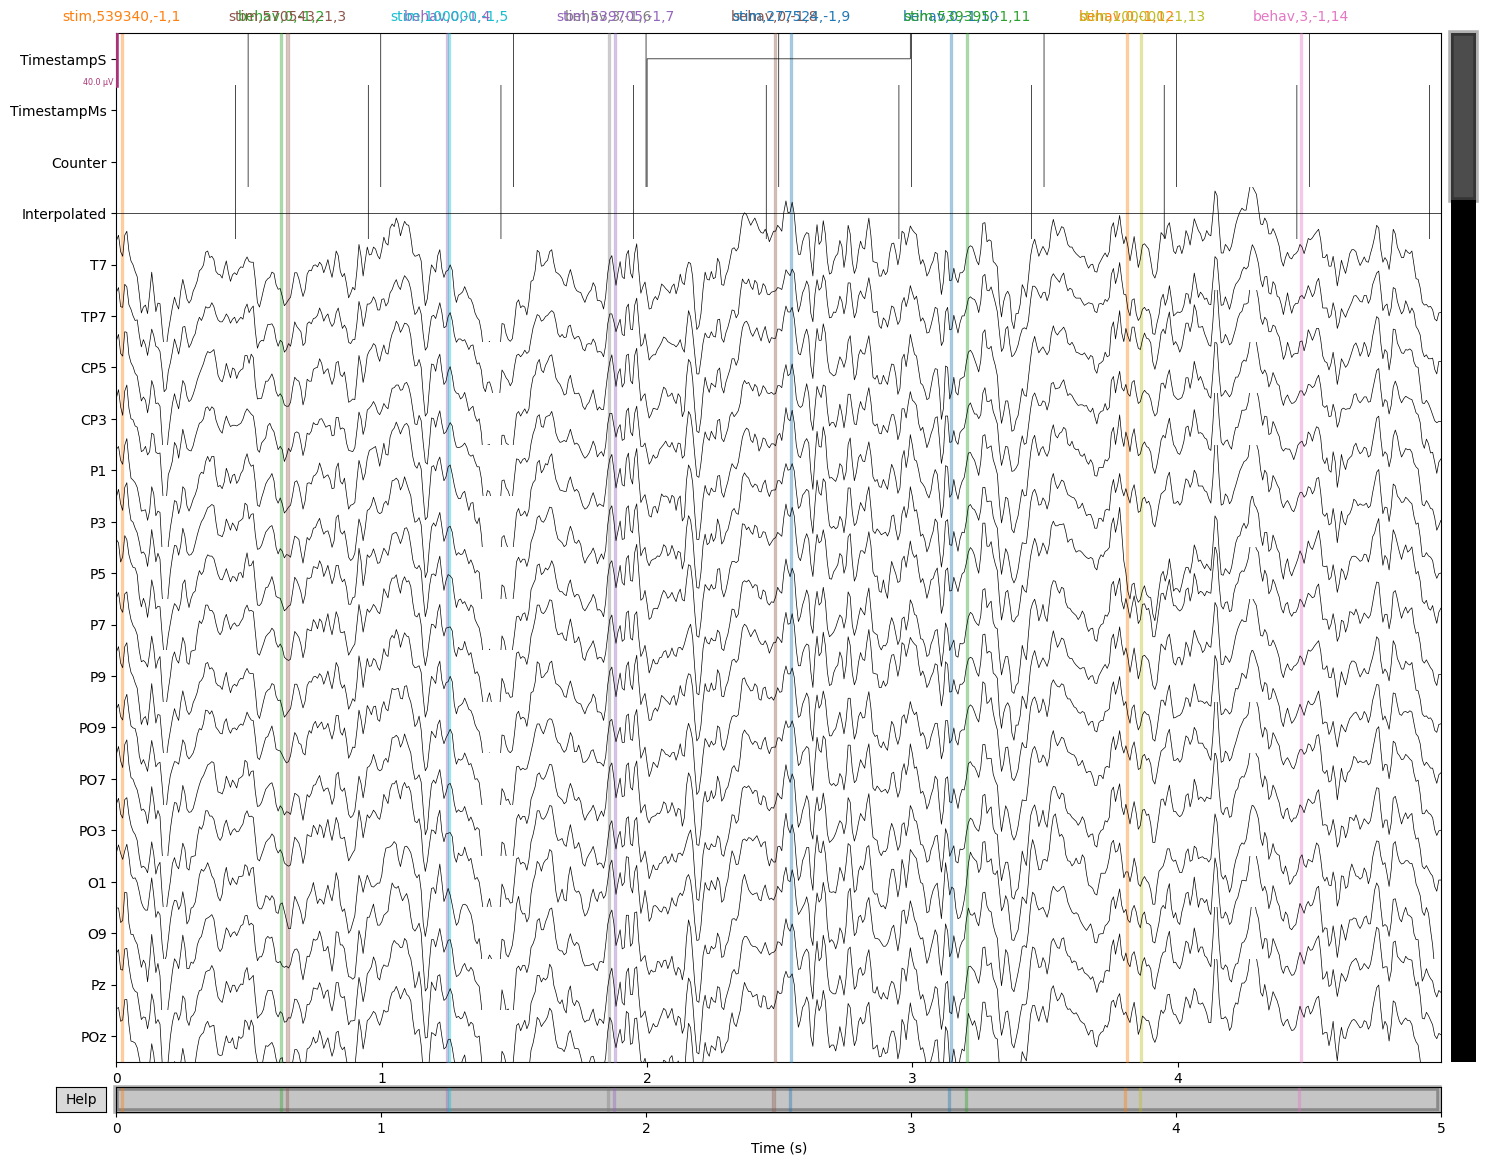

In [163]:
raw.plot()

In [164]:
# List of channel names that are EEG electrodes
eeg_channels = [
    'T7', 'TP7', 'CP5', 'CP3', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO9', 'PO7', 'PO3',
    'O1', 'O9', 'Pz', 'POz', 'Oz', 'Iz', 'O10', 'O2', 'PO4', 'PO8', 'PO10', 'P10',
    'P8', 'P6', 'P4', 'P2', 'CP4', 'CP6', 'TP8', 'T8'
]

# Restrict data to only these EEG channels using the new recommended method
raw.pick(eeg_channels)

# Load events from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)

# Create dictionaries for stimulus and behavior event IDs
stim_event_ids = {key: value for key, value in event_id.items() if key.startswith('stim')}
behav_event_ids = {key: value for key, value in event_id.items() if key.startswith('behav')}
code_to_desc = {v: k for k, v in event_id.items()}

# Since stim and behav codes increment sequentially, assume events are paired in order
dataset = []
sfreq = 128
sample_time_ms = 1000/sfreq
for i in range(len(events) - 1):  # Exclude the last event to avoid out-of-range error
    stim_time = events[i, 0]
    stim_id = events[i, 2]
    if stim_id in stim_event_ids.values():
        event_desc = code_to_desc[stim_id]  # Get the descriptive event string
        stim_value = int(event_desc.split(',')[1])  # The second item is the stimulus value

        behav_time = events[i+1, 0] 
        behav_id = events[i+1, 2]
        event_desc = code_to_desc[behav_id]
        behav_value = int(event_desc.split(',')[1])

        # Recall behavioural mapping:
        # 0: is_oddball and not space_pressed (-1 reaction time)
        # 1: not is_oddball and space_pressed
        # 2: is_oddball and space_pressed
        # 3: is_oddball and not space_pressed (-1 reaction time)
        if behav_value == 0 or behav_value == 3:
            reaction_time = None
        elif behav_value == 1 or behav_value == 2:
            reaction_time = (behav_time - stim_time)*sample_time_ms
        
        coco_id = stim_value
        if stim_value == 100000:
            prev_stim_id = events[i-2, 2]
            event_desc = code_to_desc[prev_stim_id]
            coco_id = int(event_desc.split(',')[1])
            stim_time = events[i-2, 0]
        
        record = {
            "time": stim_time*sample_time_ms,
            "coco_id": coco_id,
            "behaviour": behav_value,
            "reaction_time": reaction_time
        }

        # Save record only if record is oddball, or if record isn't oddball but next one is
        next_is_oddball = False
        if i+2 < len(events):
            next_stim_id = events[i+2,2]
            event_desc = code_to_desc[next_stim_id] 
            next_stim_value = int(event_desc.split(',')[1])
            next_is_oddball = (next_stim_value == 100000)

        if stim_value == 100000 or not next_is_oddball:
            dataset.append(record)

# epochs = mne.Epochs(raw, events, event_id=stim_event_ids, tmin=-0.05, tmax=0.60, preload=True)

Used Annotations descriptions: ['behav,0,-1,10', 'behav,0,-1,12', 'behav,0,-1,2', 'behav,0,-1,4', 'behav,0,-1,8', 'behav,3,-1,14', 'behav,3,-1,6', 'stim,100000,-1,13', 'stim,100000,-1,5', 'stim,277524,-1,9', 'stim,539340,-1,1', 'stim,539395,-1,11', 'stim,539705,-1,7', 'stim,570543,-1,3']


In [166]:
dataset

[{'time': 15.625, 'coco_id': 539340, 'behaviour': 0, 'reaction_time': None},
 {'time': 640.625, 'coco_id': 570543, 'behaviour': 3, 'reaction_time': None},
 {'time': 1875.0, 'coco_id': 539705, 'behaviour': 0, 'reaction_time': None},
 {'time': 2539.0625, 'coco_id': 277524, 'behaviour': 0, 'reaction_time': None},
 {'time': 3203.125, 'coco_id': 539395, 'behaviour': 3, 'reaction_time': None}]

In [165]:
event_id

{'behav,0,-1,10': 1,
 'behav,0,-1,12': 2,
 'behav,0,-1,2': 3,
 'behav,0,-1,4': 4,
 'behav,0,-1,8': 5,
 'behav,3,-1,14': 6,
 'behav,3,-1,6': 7,
 'stim,100000,-1,13': 8,
 'stim,100000,-1,5': 9,
 'stim,277524,-1,9': 10,
 'stim,539340,-1,1': 11,
 'stim,539395,-1,11': 12,
 'stim,539705,-1,7': 13,
 'stim,570543,-1,3': 14}